In [5]:
import numpy as np
import matplotlib.pyplot as plt

import os
import cv2

from sklearn.metrics import mean_absolute_error
from scipy.stats import norm
from sklearn.cluster import KMeans
import pandas as pd
import json

In [2]:
Root_dir = 'path/ARKitScenes/upsampling'
sample_ids = os.listdir(os.path.join(Root_dir, 'Training'))

# General Functions


In [3]:
def read_images(highre_path, lowres_path, image_path, confidence_map_path):
    highres_depth = cv2.imread(highre_path, cv2.IMREAD_ANYDEPTH)
    lowres_depth = cv2.imread(lowres_path, cv2.IMREAD_ANYDEPTH)
    conf_map = cv2.imread(confidence_map_path, cv2.IMREAD_ANYDEPTH)
    image = cv2.imread(image_path)

    return highres_depth, lowres_depth, image, conf_map


def calucalte_error_prcentage(downsampled_depth, lowres_depth, conf_map, threshold):
    downsampled_depth = downsampled_depth.astype(np.float64)
    lowres_depth = lowres_depth.astype(np.float64)
    num_pixels = downsampled_depth.shape[0] * downsampled_depth.shape[1]

    count_diff = 0

    for row in range(downsampled_depth.shape[0]):
        for col in range(downsampled_depth.shape[1]):
            if downsampled_depth[row, col] != lowres_depth[row, col]:
                error = downsampled_depth[row, col] - lowres_depth[row, col]
                if error < 0 and (conf_map[row, col] == 2 or conf_map[row, col] == 1):
                    count_diff += 1

                elif (error > threshold) and (conf_map[row, col] == 2 or conf_map[row, col] == 1):
                    count_diff += 1

    return count_diff/num_pixels

# def calucalte_error_prcentage2(downsampled_depth, lowres_depth, conf_map, threshold):
def generate_confidence(downsampled_depth, lowres_depth, conf_map, threshold):
    downsampled_depth = downsampled_depth.astype(np.float32)
    lowres_depth = lowres_depth.astype(np.float32)
    confidence_map = np.copy(conf_map)

    for row in range(downsampled_depth.shape[0]):
        for col in range(downsampled_depth.shape[1]):
            print(downsampled_depth[row, col], lowres_depth[row, col])
            if downsampled_depth[row, col] != lowres_depth[row, col]:
   
                    error = downsampled_depth[row, col] - lowres_depth[row, col]
                    if error < 0.0 and (conf_map[row, col] == 2 or conf_map[row, col] == 1):
                        confidence_map[row, col] = 0
                    if (abs(error) > threshold) and (conf_map[row, col] == 2 or conf_map[row, col] == 1):
                        confidence_map[row, col] = 0.0
                    # elif(abs(error)< threshold) and (conf_map[row, col] == 0 or conf_map[row, col] == 1):
                    #     confidence_map[row, col] = 2.0
    return confidence_map

def normalize_depth_values(downsampled_depth, lowres_depth):
    lowres_depth = lowres_depth.astype(np.float32)
    downsampled_depth = downsampled_depth.astype(np.float32)

    # make the lowres depth and downsampled depth values to be in the range of 0 to 1
    lowres_depth = lowres_depth / lowres_depth.max()
    downsampled_depth = downsampled_depth / downsampled_depth.max()

    return downsampled_depth, lowres_depth


def rescale_predicted_depth(lowres_depth, ground_truth_depth):
    # Calculate the scaling factor as the ratio of the maximum ground truth depth value
    # to the maximum predicted depth value.
    scaling_factor = np.max(ground_truth_depth) / np.max(lowres_depth)

    # Rescale the predicted depth map by multiplying it with the scaling factor.
    rescaled_predicted_depth = lowres_depth * scaling_factor

    return rescaled_predicted_depth

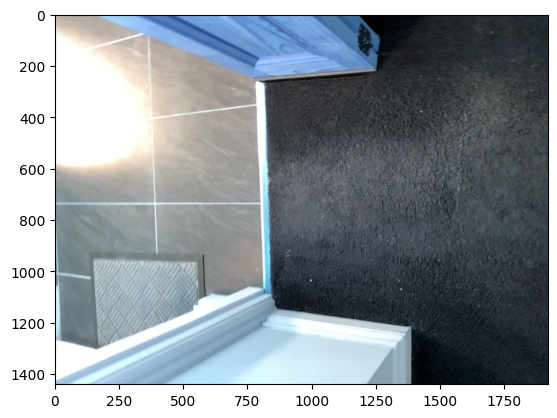

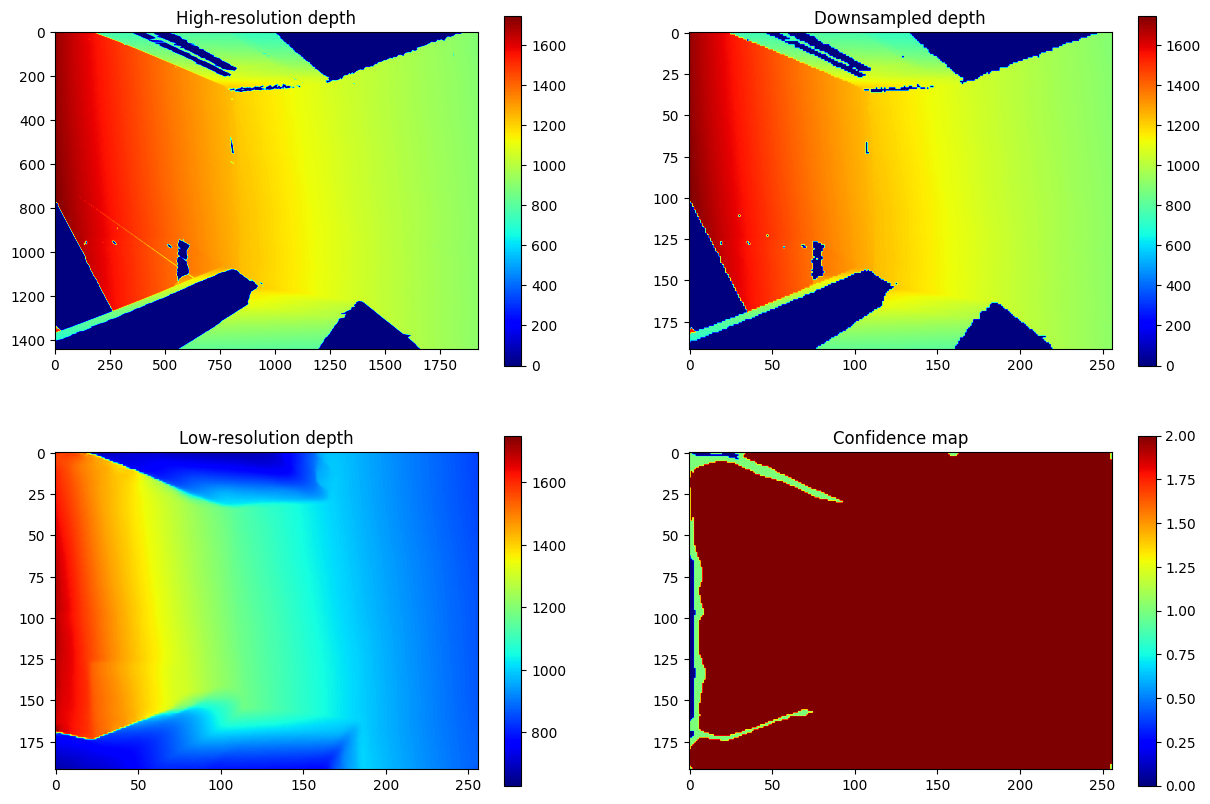

In [4]:
highre_path = 'path/ARKitScenes/upsampling/Training/48458572/highres_depth/48458572_228.288.png'
lowres_path = 'path/ARKitScenes/upsampling/Training/48458572/lowres_depth/48458572_228.288.png'
image_path = 'path/ARKitScenes/upsampling/Training/48458572/wide/48458572_228.288.png'
confidence_map_path = 'path/ARKitScenes/upsampling/Training/48458572/confidence/48458572_228.288.png'

highres_depth, lowres_depth, image, conf_map = read_images(
    highre_path, lowres_path, image_path, confidence_map_path)

# # perform a downsample on the high-resolution depth map
downsampled_depth = cv2.resize(
    highres_depth, (lowres_depth.shape[1], lowres_depth.shape[0]), interpolation=cv2.INTER_NEAREST)

# downsampled_depth, lowres_depth = normalize_depth_values(downsampled_depth, lowres_depth)
lowres_depth = rescale_predicted_depth(lowres_depth, highres_depth)
image = cv2.imread(image_path)
plt.imshow(image)

fig, ax = plt.subplots(2, 2, figsize=(15, 10))
img0 = ax[0, 0].imshow(highres_depth, cmap='jet')
ax[0, 0].set_title('High-resolution depth')
fig.colorbar(img0, ax=ax[0, 0])

img1 = ax[0, 1].imshow(downsampled_depth, cmap='jet')
ax[0, 1].set_title('Downsampled depth')
fig.colorbar(img1, ax=ax[0, 1])

img2 = ax[1, 0].imshow(lowres_depth, cmap='jet')
ax[1, 0].set_title('Low-resolution depth')
fig.colorbar(img2, ax=ax[1, 0])

img3 = ax[1, 1].imshow(conf_map, cmap='jet')
ax[1, 1].set_title('Confidence map')
fig.colorbar(img3, ax=ax[1, 1])
plt.show()

# 3288.0
# 0.0
# 3288.0


# Analyze Errors


In [8]:
errors = []

for sample_id in range(len(sample_ids)):
    print('Processing sample {}:{}'.format(sample_id+1, sample_ids[sample_id]))
    images = os.listdir(os.path.join(Root_dir, 'Training', sample_ids[sample_id], 'wide'))
    print( sample_ids[sample_id])
    lowres_depths = os.listdir(os.path.join(Root_dir, 'Training', sample_ids[sample_id], 'lowres_depth'))
    highres_depths = os.listdir(os.path.join(Root_dir, 'Training', sample_ids[sample_id], 'highres_depth'))
    confidence_maps = os.listdir(os.path.join(Root_dir, 'Training', sample_ids[sample_id], 'confidence'))

    for image_id in range(len(images)):
        highres_path = os.path.join(Root_dir, 'Training', sample_ids[sample_id], 'highres_depth', highres_depths[image_id])
        lowres_path = os.path.join(Root_dir, 'Training', sample_ids[sample_id], 'lowres_depth', lowres_depths[image_id])
        image_path = os.path.join(Root_dir, 'Training', sample_ids[sample_id], 'wide', images[image_id])
        confidence_map_path = os.path.join(Root_dir, 'Training', sample_ids[sample_id], 'confidence', confidence_maps[image_id])

        highres_depth, lowres_depth, image, conf_map = read_images(highres_path, lowres_path, image_path, confidence_map_path)
        downsampled_depth = cv2.resize(highres_depth, (lowres_depth.shape[1], lowres_depth.shape[0]), interpolation=cv2.INTER_NEAREST)
        # downsampled_depth, lowres_depth = normalize_depth_values(downsampled_depth, lowres_depth)
        lowres_depth = rescale_predicted_depth(lowres_depth, highres_depth)
        errors.append(mean_absolute_error(downsampled_depth, lowres_depth))


Processing sample 1:48458572
48458572
Processing sample 2:43828149
43828149
Processing sample 3:42447308
42447308
Processing sample 4:47204857
47204857
Processing sample 5:44796332
44796332
Processing sample 6:44796443
44796443
Processing sample 7:47204761
47204761
Processing sample 8:47331942
47331942
Processing sample 9:47204892
47204892
Processing sample 10:42446608
42446608
Processing sample 11:42897512
42897512
Processing sample 12:42444579
42444579
Processing sample 13:44358250
44358250
Processing sample 14:42898555
42898555
Processing sample 15:47669948
47669948
Processing sample 16:45261382
45261382
Processing sample 17:48018776
48018776
Processing sample 18:42897631
42897631
Processing sample 19:47115198
47115198
Processing sample 20:44358270
44358270
Processing sample 21:47332401
47332401
Processing sample 22:47334808
47334808
Processing sample 23:42897877
42897877
Processing sample 24:45261571
45261571
Processing sample 25:47430857
47430857
Processing sample 26:47430679
4743

In [9]:
# save errors
with open('../../results/ARkitScenes/csv/errors.txt', 'w') as f:
    for error in errors:
        f.write(str(error) + ',')

In [11]:
# load errors
errors = []
with open('../../results/ARkitScenes/csv/errors.txt', 'r') as f:
    errors = f.read().split(',')
    errors = [float(error) for error in errors]
print(errors)

[1602.926834577968, 268.2762002279296, 198.90978881652555, 349.60982276086463, 279.63267731951083, 146.05827713179787, 106.68488513318677, 264.1726164581793, 503.96966045897744, 237.86499276573875, 215.46025686553028, 223.65320530038306, 63.47098080825502, 173.4721883138021, 219.5395846424931, 58.77650648387771, 302.78521856398805, 337.25973018301676, 249.00178048270095, 607.0540084647654, 611.2175027184795, 391.3128415934244, 513.944874022701, 1100.0468374543757, 545.0716024153959, 627.3347963447384, 360.37647318522147, 68.02381036795823, 254.97007937165668, 3221.275264281421, 318.3945467132728, 707.2861317724442, 488.4117487742389, 263.74539593737995, 840.1215385095782, 443.1334916709126, 333.1973138303575, 335.4282197531407, 340.96628002706734, 149.7789309181541, 811.784449642396, 2018.6639410135626, 599.3565405935037, 1506.3073423943488, 464.5613680772686, 338.06848567547183, 469.1377430980816, 744.1693776773031, 68.37534971494925, 851.3236221971146, 192.06669174285918, 235.5617671

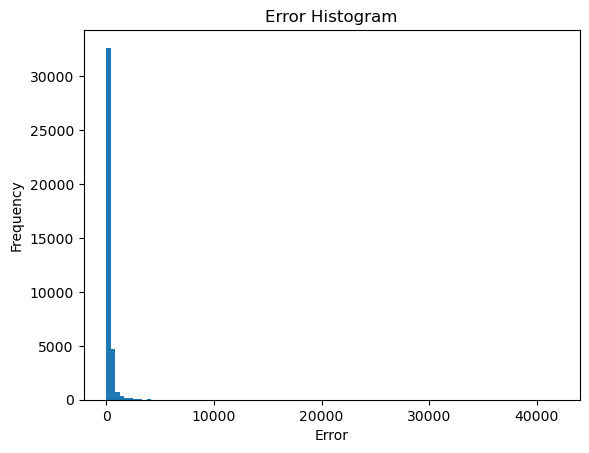

Number of frames: 39000
mean error:  319.90611254858425
median error:  189.63705350678867
max error:  41873.69389458994
min error:  1.3280212439950139
std error:  975.6792415343726
mean absolute error of MAEs:  319.90611254858425


In [12]:
plt.hist(errors, bins=100)
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Error Histogram')
plt.savefig('error_hist.png', dpi=300)
plt.show()

print(f'Number of frames: {len(errors)}')
print('mean error: ', np.mean(errors))
print('median error: ', np.median(errors))
print('max error: ', np.max(errors))
print('min error: ', np.min(errors))
print('std error: ', np.std(errors))
print('mean absolute error of MAEs: ', mean_absolute_error(errors, np.zeros(len(errors))))


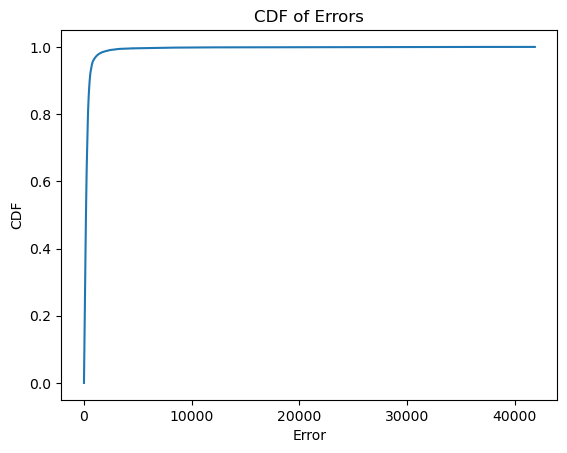

In [13]:
# Plot CDF of errors
errors = np.array(errors)
errors_sort = np.sort(errors)
cdf = np.arange(1, len(errors_sort)+1) / len(errors_sort)
plt.plot(errors_sort, cdf)
plt.xlabel('Error')
plt.ylabel('CDF')
plt.title('CDF of Errors')
plt.savefig('cdf.png', dpi=300)
plt.show()


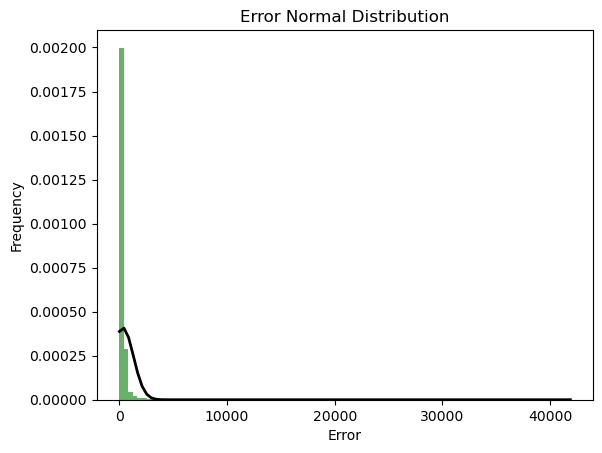

In [11]:
# Plot normal distribution of errors
mu, std = norm.fit(errors)
x = np.linspace(min(errors), max(errors), 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
plt.hist(errors, bins=100, density=True, alpha=0.6, color='g')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Error Normal Distribution')
plt.savefig('error_hist_norm.png', dpi=300)
plt.show()


/home/ashkanganj/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[1 1 1 ... 1 1 1]
Kmeans cluseter center: [[ 6942.02719866]
 [  266.37780184]
 [25198.83286577]]
7370137524.702155
11
[1 1 1 ... 1 1 1]


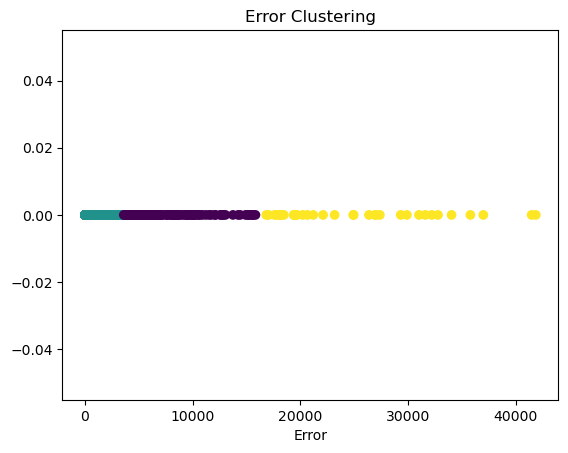

In [14]:
# Apply a clustering algorithm to the errors
kmeans = KMeans(n_clusters=3, random_state=0).fit(errors.reshape(-1, 1))
print(kmeans.labels_)
print('Kmeans cluseter center:', kmeans.cluster_centers_)
print(kmeans.inertia_)
print(kmeans.n_iter_)
print(kmeans.predict(errors.reshape(-1, 1)))

# Plot the clustering results
plt.scatter(errors, np.zeros(len(errors)), c=kmeans.labels_)
plt.xlabel('Error')
plt.title('Error Clustering')
plt.savefig('error_clustering.png', dpi=300)
plt.show()


In [16]:

threshold = (kmeans.cluster_centers_[1] + kmeans.cluster_centers_[0]) / 2
print('Threshold:', threshold)
# 47005.89463455

Threshold: [3604.20250025]


# Each frame


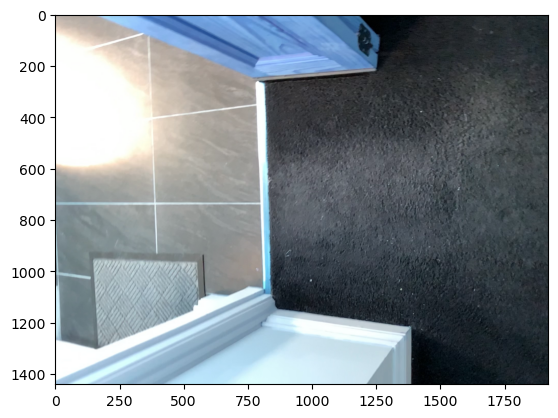

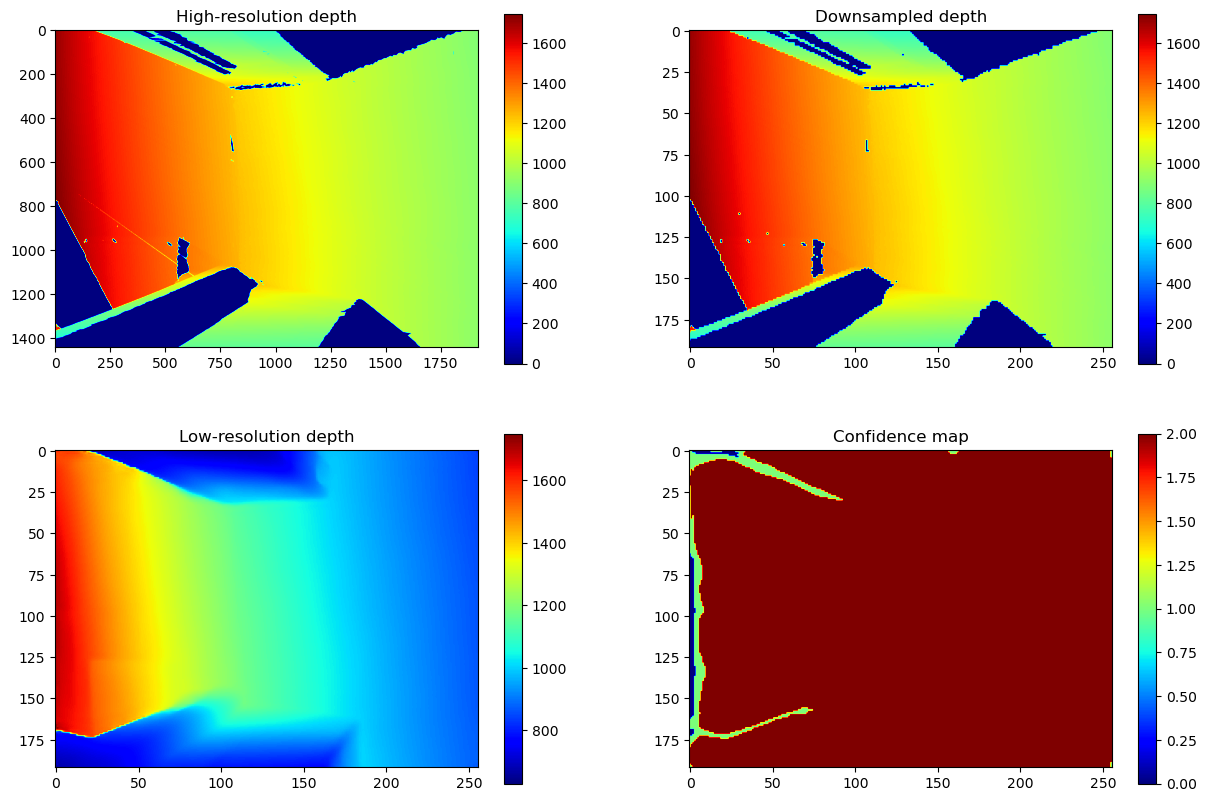

Mean Absolute Error: 215.46
0.1519 of pixels have error higher 3604.203 than which indicated as 2 in confidence map.(15.19%)


In [43]:
highre_path = 'path/ARKitScenes/upsampling/Training/48458572/highres_depth/48458572_228.288.png'
lowres_path = 'path/ARKitScenes/upsampling/Training/48458572/lowres_depth/48458572_228.288.png'
image_path = 'path/ARKitScenes/upsampling/Training/48458572/wide/48458572_228.288.png'
confidence_map_path = 'path/ARKitScenes/upsampling/Training/48458572/confidence/48458572_228.288.png'

highres_depth, lowres_depth, image, conf_map = read_images(
    highre_path, lowres_path, image_path, confidence_map_path)

# # perform a downsample on the high-resolution depth map
downsampled_depth = cv2.resize(
    highres_depth, (lowres_depth.shape[1], lowres_depth.shape[0]), interpolation=cv2.INTER_NEAREST)
lowres_depth = rescale_predicted_depth(lowres_depth, highres_depth)
# downsampled_depth_normalized, lowres_depth_normalized = normalize_depth_values(downsampled_depth, lowres_depth)

image = cv2.imread(image_path)
plt.imshow(image)

fig, ax = plt.subplots(2, 2, figsize=(15, 10))
img0 = ax[0, 0].imshow(highres_depth, cmap='jet')
ax[0, 0].set_title('High-resolution depth')
fig.colorbar(img0, ax=ax[0, 0])

img1 = ax[0, 1].imshow(downsampled_depth, cmap='jet')
ax[0, 1].set_title('Downsampled depth')
fig.colorbar(img1, ax=ax[0, 1])

img2 = ax[1, 0].imshow(lowres_depth, cmap='jet')
ax[1, 0].set_title('Low-resolution depth')
fig.colorbar(img2, ax=ax[1, 0])

img3 = ax[1, 1].imshow(conf_map, cmap='jet')
ax[1, 1].set_title('Confidence map')
fig.colorbar(img3, ax=ax[1, 1])
plt.show()

mae = mean_absolute_error(downsampled_depth, lowres_depth)
percentage = calucalte_error_prcentage(
    downsampled_depth, lowres_depth, conf_map, threshold[0])
print(f'Mean Absolute Error: {mae:.2f}')
print(f'{percentage:.4f} of pixels have error higher {threshold[0]:.3f} than which indicated as 2 in confidence map.({percentage*100:.2f}%)')


Threshold [3604.20250025]
1715.0 1563.0182
1707.0 1560.1273
1699.0 1561.091
1692.0 1554.3455
1684.0 1554.3455
1677.0 1548.5636
1670.0 1543.7455
1663.0 1564.9454
1656.0 1540.8545
1649.0 1548.5636
1643.0 1560.1273
1639.0 1549.5272
1632.0 1531.2181
1626.0 1525.4364
1620.0 1524.4728
1614.0 1493.6364
1608.0 1524.4728
1602.0 1537.9636
1596.0 1488.8182
1591.0 863.41815
1584.0 702.4909
1579.0 630.2182
746.0 641.7818
746.0 642.7455
746.0 654.3091
746.0 662.9818
746.0 663.94543
746.0 670.6909
746.0 673.58185
746.0 681.2909
747.0 686.1091
747.0 692.85455
747.0 694.7818
747.0 696.7091
747.0 698.63635
747.0 700.56366
747.0 702.4909
747.0 703.4545
747.0 705.38184
747.0 706.34546
747.0 706.34546
747.0 707.3091
747.0 706.34546
747.0 708.2727
746.0 709.2364
0.0 710.2
0.0 709.2364
0.0 708.2727
0.0 707.3091
0.0 708.2727
0.0 708.2727
0.0 708.2727
0.0 709.2364
758.0 710.2
758.0 710.2
759.0 710.2
760.0 711.16364
760.0 711.16364
0.0 711.16364
0.0 710.2
0.0 709.2364
0.0 708.2727
0.0 706.34546
0.0 705.38184
0.

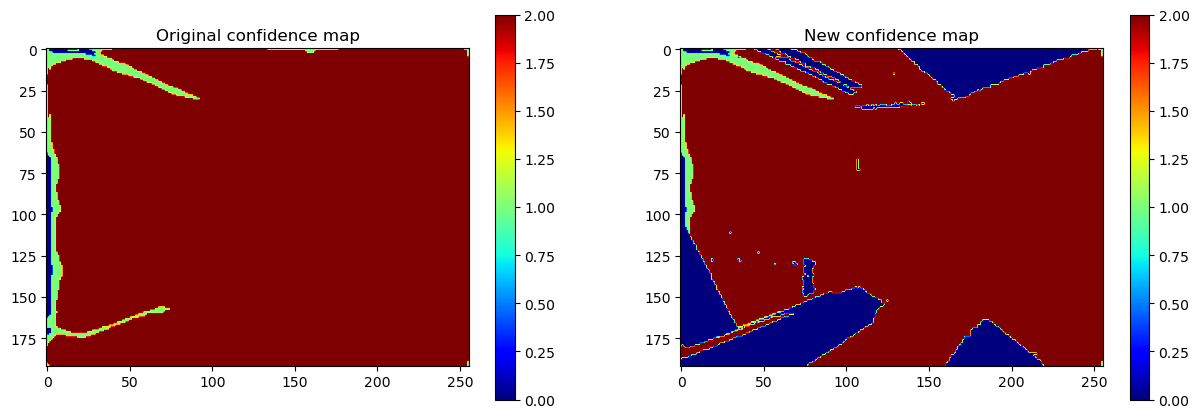

In [44]:
print('Threshold', threshold)
new_conf_map = generate_confidence(
    downsampled_depth, lowres_depth, conf_map, threshold)
mae = mean_absolute_error(new_conf_map, conf_map)

print(f'Mean Absolute Error between confidence maps: {mae:.2f}')

# show two confdiece maps side by side
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
img0 = ax[0].imshow(conf_map, cmap='jet')
ax[0].set_title('Original confidence map')
fig.colorbar(img0, ax=ax[0])

img1 = ax[1].imshow(new_conf_map, cmap='jet')
ax[1].set_title('New confidence map')
fig.colorbar(img1, ax=ax[1])
plt.savefig('confidence_map_comparison.png', dpi=300)
plt.show()


# Generate a json file for error of each frame based on GT

In [ ]:
results = []

print('Threshold:',threshold[0])
print('Number of samples',len(sample_ids))

for sample_id in range(len(sample_ids)):
    results.append({sample_ids[sample_id]: []})
    print('Processing sample {}:{}'.format(sample_id+1, sample_ids[sample_id]))

    images = os.listdir(os.path.join(Root_dir, 'Training', sample_ids[sample_id], 'wide'))
    print( sample_ids[sample_id])

    lowres_depths = os.listdir(os.path.join(Root_dir, 'Training', sample_ids[sample_id], 'lowres_depth'))
    highres_depths = os.listdir(os.path.join(Root_dir, 'Training', sample_ids[sample_id], 'highres_depth'))
    confidence_maps = os.listdir(os.path.join(Root_dir, 'Training', sample_ids[sample_id], 'confidence'))

    for image_id in range(len(images)):
        highres_path = os.path.join(Root_dir, 'Training', sample_ids[sample_id], 'highres_depth', highres_depths[image_id])
        lowres_path = os.path.join(Root_dir, 'Training', sample_ids[sample_id], 'lowres_depth', lowres_depths[image_id])
        image_path = os.path.join(Root_dir, 'Training', sample_ids[sample_id], 'wide', images[image_id])
        confidence_map_path = os.path.join(Root_dir, 'Training', sample_ids[sample_id], 'confidence', confidence_maps[image_id])

        highres_depth, lowres_depth, image, conf_map = read_images(highres_path, lowres_path, image_path, confidence_map_path)
        downsampled_depth = cv2.resize(highres_depth, (lowres_depth.shape[1], lowres_depth.shape[0]), interpolation=cv2.INTER_NEAREST)

        percentage = calucalte_error_prcentage(downsampled_depth, lowres_depth, conf_map, threshold[0])

        results[sample_id][sample_ids[sample_id]].append(percentage)

        with open('results.json', 'w') as fp:
            json.dump(results, fp)


In [62]:
# read the results from the json file
with open('results.json', 'r') as fp:
    results = json.load(fp)


print('Number of samples:', len(results))
# calculate the average error percentage for each sample
average_error = []
for sample in results:
    sample_id = list(sample.keys())[0]
    average_error.append(np.mean(sample[sample_id]))

print(f'Average error percentage:{np.mean(average_error):.2f}')
print('-----------------------------------------------------------------')

print('Number of samples with mean error percentage less than 10%:',
      len([x for x in average_error if x < 0.1]))
print('Number of samples with mean error percentage higher than 10%:',
      len([x for x in average_error if x > 0.1]))
print('Number of samples with mean error percentage higher than 20%:',
      len([x for x in average_error if x > 0.2]))
print('Number of samples with mean error percentage higher than 30%:',
      len([x for x in average_error if x > 0.3]))

print('-----------------------------------------------------------------')
# number of all frames
num_all_frames = len(
    [x for sample in results for x in sample[list(sample.keys())[0]]])
print('Number of all frames:', num_all_frames)
# calculate the number frames with error percentage higher than 10% for each sample
number_of_frames = []
for sample in results:
    sample_id = list(sample.keys())[0]
    number_of_frames.append(len([x for x in sample[sample_id] if x > 0.2]))

print( 
    f'Number of frames with error percentage higher than 20%:{np.sum(number_of_frames)}({(np.sum(number_of_frames)/num_all_frames )*100:.2f}%)')
# calculate avervage error percentage for all frames

# get average error percentage for all frames
all_frames = [x for sample in results for x in sample[list(sample.keys())[0]]]
print(f'Average error percentage for all frames:{np.mean(all_frames):.2f}')

Number of samples: 1970
Average error percentage:0.21
-----------------------------------------------------------------
Number of samples with mean error percentage less than 10%: 21
Number of samples with mean error percentage higher than 10%: 1949
Number of samples with mean error percentage higher than 20%: 1056
Number of samples with mean error percentage higher than 30%: 181
-----------------------------------------------------------------
Number of all frames: 39000
Number of frames with error percentage higher than 20%:18057(46.30%)
Average error percentage for all frames:0.21


In [55]:

num_all_frames = len(
    [x for sample in results for x in sample[list(sample.keys())[0]]])
print('Number of all frames:', num_all_frames)
# calculate the number frames with error percentage higher than 10% for each sample
number_of_frames = []
for sample in results:
    sample_id = list(sample.keys())[0]
    number_of_frames.append(len([x for x in sample[sample_id] if x > 0.1]))

print( 
    f'Number of frames with error percentage higher than 10%:{np.sum(number_of_frames)}({(np.sum(number_of_frames)/num_all_frames )*100:.2f}%)')


Number of all frames: 39000
Number of frames with error percentage higher than 10%:30610(78.49%)
